# Vortices in Potential Flow

In this notebook we will produce sample data using potential flow as a numerical laboratory to experiment and prototype different vorticy identifying techniques. In this particular example, we will focus on the FTLE method.

For the derivation of the equations used in this computation, refer to the potential flow notes at https://goo.gl/J2BmKz

-- Richard Galvez, May 2015

____________________________________________________________________________________

First we will include standard libraries to do our calculations:

In [8]:
import numpy
import math
from matplotlib import pyplot
import time
import sys

%matplotlib inline

- Numpy is a python library for doing numerical computations that also is optimized to do calculations as quickly as possible utilizing vectors and matricies (much like Matlab)
- math is pretty straight forward
- matplotlib is another module that supplies plotting and visualization features, again like Matlab, but more robust.
- time, sys for utilities.

Next we define a freestream class to demonstrate the use of classes in Python

In [9]:
class Freestream:
    """Freestream conditions."""
    def __init__(self, u_inf=1.0, alpha=0.0):
        """Sets the freestream conditions.
        
        Arguments
        ---------
        u_inf -- Farfield speed (default 1.0).
        alpha -- Angle of attack in degrees (default 0.0).
        """
        self.u_inf = u_inf
        self.alpha = alpha*math.pi/180          # degrees --> radians

and also define a function to return the velocity of a vortex.

In [10]:
def get_velocity_vortex(strength, xv, yv, X, Y):
    """Returns the velocity field generated by a vortex.
    
    Arguments
    ---------
    strength -- strength of the vortex.
    xv, yv -- coordinates of the vortex.
    X, Y -- mesh grid.
    """
    u = + strength/(2*math.pi)*(Y-yv)/((X-xv)**2+(Y-yv)**2)
    v = - strength/(2*math.pi)*(X-xv)/((X-xv)**2+(Y-yv)**2)
    
    return u, v

## FTLE Method

We first investigate the case of a single vortex in the presence of a stream whos strength depends on x. 

I meant to do just a uniform freestream but accidentally made it depend on x. Actually, it ends up producing interesting dynamics.

Let's start by defining the mesh (we'll also keep the same mesh for the various examples): 


In [20]:
N = 120
x_start, x_end = -2.0, 2.0
y_start, y_end = -1.0, 1.0

x = numpy.linspace(x_start, x_end, N)
y = numpy.linspace(y_start, y_end, N)

X, Y = numpy.meshgrid(x, y)

Next we'll introduce the flow producing elements. First we define a freestream using the Freesteam constructor (we defined above) with the strength set to 1.0 and the angle of attack set to 0. 

Then define the strength and location of the vortex.

In [21]:
freestream = Freestream(1.0, 0.0) # Strength of the freestream, and angle of attack

gamma = 5.0                       # strength of the vortex
x_vortex, y_vortex = (0.0, 0.0)    # location of vortex1

Now that we have a vortex, it's strength and a freestream field, we can calculate the flow within our mesh.

In [22]:
u, v = get_velocity_vortex(gamma, x_vortex, y_vortex, X, Y)
u += freestream.u_inf * X * numpy.cos(freestream.alpha)
v += freestream.u_inf * Y * numpy.sin(freestream.alpha)

The u and v fields for the vortex are first computed and then the faux freestream addition is included. Also notice we used the superposition property of potential flow theory in this situation. 

### Stream plot

We can visualize the flow produced by this configuration by looking at a stream plot of the u and v fields:


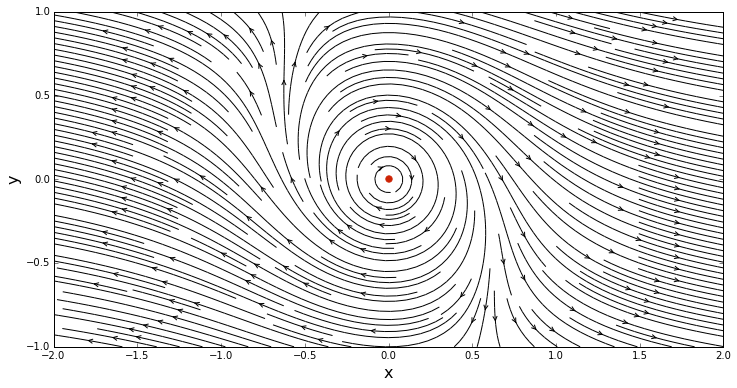

In [24]:
size = 12 # Size of the image displayed only in this notebook.

# Where to save the pdf image file. Note you can use png, eps, etc for different
# formats

fileName = '/Users/richardgalvez/Dropbox/slosh/vortices/central_vortex_flow_streamplot.pdf'

fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=40, marker='o')
pyplot.draw()
    
fig.savefig(fileName)

And the quiver:

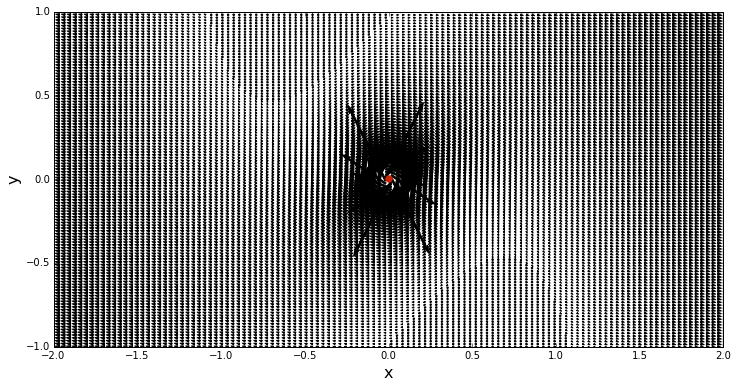

In [25]:
size = 12 # Size of the image displayed only in this notebook.

# Where to save the pdf image file. Note you can use png, eps, etc for different
# formats

fileName = '/Users/richardgalvez/Dropbox/slosh/vortices/central_vortex_quiver.pdf'

fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
pyplot.quiver(X, Y, u, v, linewidth=1, color='k')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=40, marker='o')
pyplot.draw()
    
fig.savefig(fileName)

###Trajectory analysis

To be sure that our FTLE code is calculating the correct trajectories, we can first plot some and see how they look.

In order to do that, the first step is to define a bilinear interpolation function http://en.wikipedia.org/wiki/Bilinear_interpolation. 

One interesting thing to notice here is how I took care of the boundary conditions. In this first naive run through, I simply decided that if the point lied outside of the boundaries of our space, then it should take the value that it had at the boundary.

In [28]:
def bilinear_interpolation(X, Y, f, x, y):
    """Returns the approximate value of f(x,y) using bilinear interpolation.
    
    Arguments
    ---------
    X, Y -- mesh grid.
    f -- the function f that should be an NxN matrix.
    x, y -- coordinates where to compute f(x,y)
    
    """
    
    N = numpy.shape(X[:,0])[0]

    dx, dy = X[0,1] - X[0,0], Y[1,0] - Y[0,0]
    x_start, y_start = X[0,0], Y[0,0] 
    
    
    i1, i2 = int ((x - x_start)/dx) , int((x - x_start)/dx) + 1
    j1, j2 = int ((y - y_start)/dy) , int((y - y_start)/dy) + 1
    
    
    # Take care of boundaries
    
    # 1. Right boundary
    
    if i1 >= N-1 and j1 <= N-1 and j1 >= 0:
        return f[j1, N-1]
    if i1 >= N-1 and j1 <= 0 :
        return f[0, N-1]
    if i1 >= N-1 and j1 >= N-1 :
        return f[N-1, N-1]
    
    # 2. Left boundary
    
    if i1 <= 0 and j1 <= N-1 and j1 >= 0:
        return f[j1, 0]
    if i1 <= 0 and j1 <= 0 :
        return f[0, 0]
    if i1 <= 0 and j1 >= N-1 :
        return f[N-1, 0]
    
    # 3. Top boundary
    
    if j1 >= N-1 and i1<=N-1 and i1>=0:
        return f[N-1, i1]
    if j1 >= N-1 and i1 <= 0 :
        return f[N-1, 0]
    
    # 3. Bottom boundary
    
    if j1 <= 0 and i1<=N-1 and i1>=0:
        return f[0, i1]
    if j1 <= 0 and i1 >= N-1 :
        return f[N-1, 0]
    

    x1, x2 = X[j1,i1], X[j2,i2]
    y1, y2 = Y[j1,i1], Y[j2,i2]
    
    f_interpolated = ( 1/(x2-x1)*1/(y2-y1) *
                      ( f[j1,i1]*(x2-x)*(y2-y) + f[j1,i2]*(x-x1)*(y2-y) 
                      + f[j2,i1]*(x2-x)*(y-y1) + f[j2,i2]*(x-x1)*(y-y1)) ) 
    
    return f_interpolated

The next thing we will need is a Runge-Kutta integrator to 4th order. I found that the use of this integrator was good enough for our purposes. In the near future however, it might be a good idea to implement an adaptive time feature.

In [29]:
def rk4(X, Y, x, y, f, h, dim):
    """Returns the approximate value of f(x,y) using bilinear interpolation.
    
    Arguments
    ---------
    X, Y -- mesh grid.
    x, y -- coordinates where to begin the evolution.
    f -- the function f that will be evolved.
    h -- the time step (usually referred to this as dt.)
    dim -- 0 for x and 1 for y.
    
    """
    
    k1 = h * bilinear_interpolation(X, Y, f, x, y)
    k2 = h * bilinear_interpolation(X, Y, f, x + 0.5 * h, y + 0.5 * k1)
    k3 = h * bilinear_interpolation(X, Y, f, x + 0.5 * h, y + 0.5 * k2)
    k4 = h * bilinear_interpolation(X, Y, f, x + h      , y + k3)
    
    if dim == 0:
        return x + 1./6 * k1 + 1./3 * k2 + 1./3 * k3 + 1./6 * k4
    elif dim == 1:
        return y + 1./6 * k1 + 1./3 * k2 + 1./3 * k3 + 1./6 * k4
    else:
        #print 'invalid dimension parameter passed to rk4, exiting'
        sys.exit()

We next define a function that tests that the trajectories 

a) follow the flow lines, and

b) are integrated long enough to sample the domain.

In [34]:
def test_trajectory(X, Y, i, j, integration_time, dt):
    """ Plots the trajectories of a few particles
    
    Arguments
    ---------
    X, Y -- mesh grid.
    i, j -- indices of the first particle on the mesh.
    integration_time -- the duration of the integration
    dt -- the finess of the time integration space.
    
    """

    size = 12
    fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
    fileName = '/Users/richardgalvez/Dropbox/slosh/vortices/vortex1_sample_traj.pdf'

    pyplot.xlim(x_start*1.5, x_end*1.5)
    pyplot.ylim(y_start*1.5, y_end*1.5) 

    xs, ys = X[j,i], Y[j, i]

    traj_x , traj_y = numpy.zeros((N,N)), numpy.zeros((N,N))

    traj_x[j][i], traj_y[j][i] = xs, ys

    print '(x0s, y0s) ->', xs, ys

    print 'begining trajectory calculation'
    
    colors = ['r','k','c'] # To plot more particles, add more colors
    
    for l, c in enumerate(colors):

        for k in xrange(0, int(integration_time/dt)):
        
            xs, ys = rk4(X, Y, xs, ys, u, dt, 0), rk4(X, Y, xs, ys, v, dt, 1) 
            traj_x[j][i] += xs
            traj_y[j][i] += ys
    
            #print '(xs, ys) ->', xs, ys
            pyplot.scatter(xs, ys, s=5, color = c)
            #print k*dt
        
        i += 1
        j += 1
    
        xs, ys = X[j,i], Y[j, i]
    
    pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
    pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=25, marker='o')
    fig.savefig(fileName)
    
    return None


(x0s, y0s) -> 0.0168067226891 0.00840336134454
begining trajectory calculation
the elapsed time is  7.33436512947


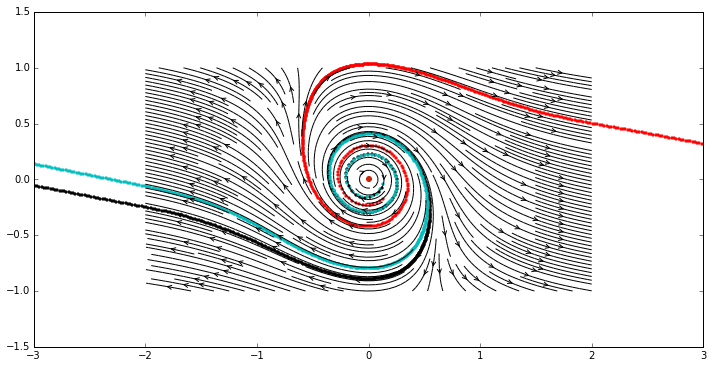

In [35]:
start = time.time()
test_trajectory(X, Y, N/2 , N/2, 8, 0.01)
print 'the elapsed time is ', time.time() - start

Let's define a general function to compute all trajectories:

In [39]:
def get_traj(X, Y, u, v, integration_time, dt):
    """ Returns the FTLE particle trajectory
    
    Arguments
    ---------
    x, y -- mesh grid coordinates
    dt -- integral time step
    """
    N = numpy.shape(X[:,1])[0]
    x = X[0,:]
    y = Y[:,0]
    
    traj_x = numpy.zeros((N,N), dtype=numpy.float)
    traj_y = numpy.zeros((N,N), dtype=numpy.float)
    
    for i, xx in enumerate(x):
        for j, yy in enumerate(y):
            xs, ys = xx, yy
            traj_x[j][i], traj_y[j][i] = xs, ys
            for k in xrange(0, int(integration_time/dt)):
                
                xs, ys = rk4(X, Y, xs, ys, u, dt, 0), rk4(X, Y, xs, ys, v, dt, 1) 
                traj_x[j][i] += xs
                traj_y[j][i] += ys
                 
    return traj_x, traj_y

And now that we have the trajectories, we can calculate the FTLE field

In [36]:
def get_ftle(traj_x, traj_y, X, Y, integration_time):
    """ Returns the FTLE scalar field
    
    Mostly adapted from Steven's FTLE code (GitHub user stevenliuyi)
    
    Arguments
    ---------
    traj_x, traj_y -- The trajectories of the FTLE particles
    X, Y -- Meshgrid
    integration_time -- the duration of the integration time
    
    """
    
    N = numpy.shape(X[:,0])[0]
    ftle = numpy.zeros((N,N))
    
    for i in range(0,N):
        for j in range(0,N):
            # index 0:left, 1:right, 2:down, 3:up
            xt = numpy.zeros(4); yt = numpy.zeros(4)
            xo = numpy.zeros(2); yo = numpy.zeros(2)

            if (i==0):
                xt[0] = traj_x[j][i]; xt[1] = traj_x[j][i+1]
                yt[0] = traj_y[j][i]; yt[1] = traj_y[j][i+1]
                xo[0] = X[j][i];      xo[1] = X[j][i+1]
            elif (i==N-1):
                xt[0] = traj_x[j][i-1]; xt[1] = traj_x[j][i]
                yt[0] = traj_y[j][i-1]; yt[1] = traj_y[j][i]
                xo[0] = X[j][i-1]; xo[1] = X[j][i]
            else:
                xt[0] = traj_x[j][i-1]; xt[1] = traj_x[j][i+1]
                yt[0] = traj_y[j][i-1]; yt[1] = traj_y[j][i+1]
                xo[0] = X[j][i-1]; xo[1] = X[j][i+1]

            if (j==0):
                xt[2] = traj_x[j][i]; xt[3] = traj_x[j+1][i]
                yt[2] = traj_y[j][i]; yt[3] = traj_y[j+1][i]
                yo[0] = Y[j][i]; yo[1] = Y[j+1][i]
            elif (j==N-1):
                xt[2] = traj_x[j-1][i]; xt[3] = traj_x[j][i]
                yt[2] = traj_y[j-1][i]; yt[3] = traj_y[j][i]
                yo[0] = Y[j-1][i]; yo[1] = Y[j][i]
            else:
                xt[2] = traj_x[j-1][i]; xt[3] = traj_x[j+1][i]
                yt[2] = traj_y[j-1][i]; yt[3] = traj_y[j+1][i]
                yo[0] = Y[j-1][i]; yo[1] = Y[j+1][i]
        
            lambdas = eigs(xt, yt, xo, yo)
            if lambdas=='nan':
                ftle[j][i] = float('nan')
            else:
                ftle[j][i] = .5*numpy.log(max(lambdas))/(integration_time)
    
    return ftle

In [37]:
def eigs(xt, yt, xo, yo):
    ftlemat = numpy.zeros((2,2))
    ftlemat[0][0] = (xt[1]-xt[0])/(xo[1]-xo[0])
    ftlemat[1][0] = (yt[1]-yt[0])/(xo[1]-xo[0])
    ftlemat[0][1] = (xt[3]-xt[2])/(yo[1]-yo[0])
    ftlemat[1][1] = (yt[3]-yt[2])/(yo[1]-yo[0])
    
    if (True in numpy.isnan(ftlemat)): 
        return 'nan'
    
    ftlemat = numpy.dot(ftlemat.transpose(), ftlemat)
    w, v = numpy.linalg.eig(ftlemat)

    return w

## FTLE results

First we take a look at the x-dependent stream mixed with the center placed vortex.

the elapsed time is  203.988749981


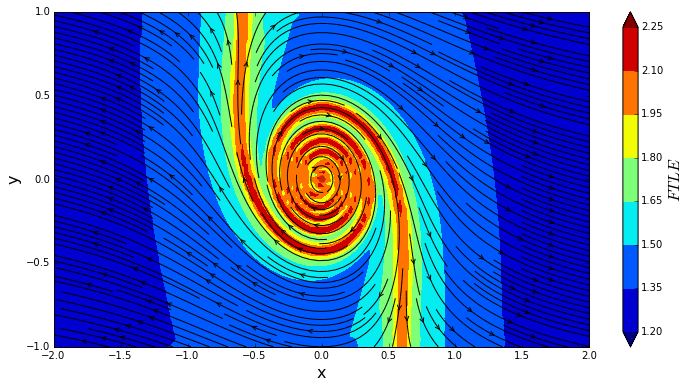

In [43]:
start = time.time()

integration_time, dt = 5, 0.01

size = 12
fileName = '/Users/richardgalvez/Dropbox/slosh/vortices/fixed_vortex1_ftle.pdf'

x_vortex, y_vortex = (0.0, 0.0)    # location of vortex1

u, v = get_velocity_vortex(gamma, x_vortex, y_vortex, X, Y)
u += freestream.u_inf * X * numpy.cos(freestream.alpha)
v += freestream.u_inf * Y * numpy.sin(freestream.alpha)

traj_x, traj_y = get_traj(X, Y, u, v, integration_time, dt)
ftle = get_ftle(traj_x, traj_y, X, Y, integration_time)

    
fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
contf = pyplot.contourf(X, Y, ftle, extend='both')
cbar = pyplot.colorbar(contf)

cbar.set_label('$FTLE$', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=40, marker='o')
pyplot.draw()
    
fig.savefig(fileName)

print 'the elapsed time is ', time.time() - start

As another example, consider a center-placed vortex in the presence of a freestream field:

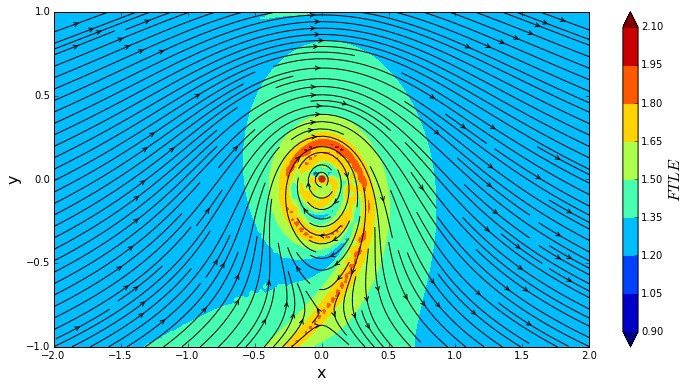

In [46]:
size = 12
fileName = '/Users/richardgalvez/Dropbox/slosh/vortices/single_vortex_freestream_FTLE.pdf'

integration_time, dt = 5, 0.01

x_vortex, y_vortex = (0.0, 0.0)    # location of vortex1
grid = numpy.ones((N,N))

u, v = get_velocity_vortex(gamma, x_vortex, y_vortex, X, Y)
u += freestream.u_inf * grid * numpy.cos(freestream.alpha)
v += freestream.u_inf * grid * numpy.sin(freestream.alpha)

traj_x, traj_y = get_traj(X, Y, u, v, integration_time, dt)
ftle = get_ftle(traj_x, traj_y, X, Y, integration_time)

    
fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
contf = pyplot.contourf(X, Y, ftle, extend='both')
cbar = pyplot.colorbar(contf)

cbar.set_label('$FTLE$', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
#pyplot.quiver(X, Y, u, v, linewidth=1, color='g')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=40, marker='o')
#pyplot.scatter(x_vortex2, y_vortex2, color='#CD2305', s=40, marker='o')
pyplot.draw()
    
fig.savefig(fileName)

And lastly, two vortices in the presence of a freestream field.

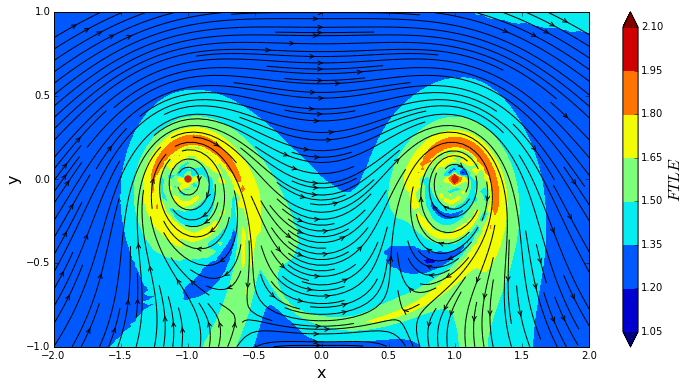

In [47]:
size = 12
fileName = '/Users/richardgalvez/Dropbox/slosh/vortices/vortex2_full_8_01.pdf'

integration_time, dt = 5, 0.01

x_vortex, y_vortex = (-1.0, 0.0)    # location of vortex1

u, v = get_velocity_vortex(gamma, x_vortex, y_vortex, X, Y)
u += freestream.u_inf * grid * numpy.cos(freestream.alpha)
v += freestream.u_inf * grid * numpy.sin(freestream.alpha)

x_vortex2, y_vortex2 = (1.0, 0.0)    # location of vortex2
u += get_velocity_vortex(gamma, x_vortex2, y_vortex2, X, Y)[0]
v += get_velocity_vortex(gamma, x_vortex2, y_vortex2, X, Y)[1]

traj_x, traj_y = numpy.zeros((N,N)), numpy.zeros((N,N))
traj_x, traj_y = get_traj(X, Y, u, v, integration_time, dt)
ftle = get_ftle(traj_x, traj_y, X, Y, integration_time)

    
fig = pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)                                                           
    
contf = pyplot.contourf(X, Y, ftle, extend='both')
cbar = pyplot.colorbar(contf)

cbar.set_label('$FTLE$', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->', color='k')
#pyplot.quiver(X, Y, u, v, linewidth=1, color='g')
pyplot.scatter(x_vortex, y_vortex, color='#CD2305', s=40, marker='o')
pyplot.scatter(x_vortex2, y_vortex2, color='#CD2305', s=40, marker='o')
pyplot.draw()
    
fig.savefig(fileName)

In [19]:
# This cell just imports a CSS template for the styling and formatting of this 

from IPython.core.display import HTML
def css_styling():
    styles = open('styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()